A simple RNN that is trained to count how many 1's it sees on a binary input stream, and output the total count at the end of the sequence.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.colors import LogNorm
from IPython.display import Image

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Rprop

In [2]:
# Create dataset
num_of_samples = 20
sequence_len   = 10
# Create the sequences
X = np.zeros((num_of_samples, sequence_len))
for row in range(num_of_samples):
    X[row,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Create the targets for each sequence
t = np.sum(X, axis=1)

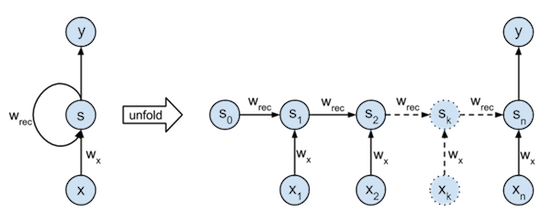

In [3]:
Image(filename='SimpleRNN01.png')

The recurrence relation to propagate the gradients can be written as:

$$\frac{\partial \xi}{\partial S_{k-1}} 
= \frac{\partial \xi}{\partial S_{k}} \frac{\partial S_{k}}{\partial S_{k-1}}
= \frac{\partial \xi}{\partial S_{k}} w_{rec}$$

starting at:

$$\frac{\partial \xi}{\partial y} = \frac{\partial \xi}{\partial S_{n}}$$

The gradients of the cost function with respect to the parameters can then be found by summing the parameter gradients in each layer

$$\frac{\partial \xi}{\partial w_x} 
= \sum_{k=0}^{n} \frac{\partial \xi}{\partial S_{k}} x_k
\\
\frac{\partial \xi}{\partial w_{rec}} 
= \sum_{k=1}^{n} \frac{\partial \xi}{\partial S_{k}} S_{k-1}$$

In [4]:
# Define the forward step functions
def update_state(xk, sk, wx, wRec):
    """
    Compute state k from the previous state (sk) and current input (xk),
    by use of the input weights (wx) and recursive weights (wRec).
    """
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    """
    Unfold the network and compute all state activations given the input X,
    and input weights (wx) and recursive weights (wRec).
    Return the state activations in a matrix, the last column S[:,-1] contains the
    final activations.
    """
    # Initialise the matrix that holds all states for all input sequences.
    # The initial state s0 is set to 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))
    # Use the recurrence relation defined by update_state to update the 
    #  states trough time.
    for k in range(X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S

def cost(y, t): 
    """
    Return the MSE between the targets t and the outputs y.
    """
    return ((t - y)**2).sum() / num_of_samples

def output_gradient(y, t):
    """
    Compute the gradient of the MSE cost function with respect to the output y.
    """
    return 2.0 * (y - t) / num_of_samples

def backward_gradient(X, S, grad_out, wRec):
    """
    Backpropagate the gradient computed at the output (grad_out) through the network.
    Accumulate the parameter gradients for wX and wRec by for each layer by addition.
    Return the parameter gradients as a tuple, and the gradients at the output of each layer.
    """
    # Initialise the array that stores the gradients of the cost with respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Set the gradient accumulations to 0
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results.
        wx_grad += np.sum(grad_over_time[:,k] * X[:,k-1])
        wRec_grad += np.sum(grad_over_time[:,k] * S[:,k-1])
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

# Define Rprop optimisation function
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Update Rprop values in one iteration.
    X: input data.
    t: targets.
    W: Current weight parameters.
    W_prev_sign: Previous sign of the W gradient.
    W_delta: Rprop update values (Delta).
    eta_p, eta_n: Rprop hyperparameters.
    """
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)  # Sign of new gradient
    # Update the Delta (update value) for each weight parameter seperately
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

In [5]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W

for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(X, t, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    
print('Final weights are: wx = {0},  wRec = {1}'.format(W[0], W[1]))

Final weights are: wx = 1.0073721855130566,  wRec = 0.998340534955843


In [219]:
test_inpt = np.asmatrix([[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
print('Target output: {:d} vs Model output: {:.2f}'.format(test_inpt.sum(), test_outpt[0]))

Target output: 5 vs Model output: 5.00


## PyTorch implementation

In [251]:
input0 = Variable(torch.from_numpy(X.T).type(torch.FloatTensor)).view(10,20,1)
h0     = Variable(torch.zeros(1,20,1).type(torch.FloatTensor))
target = Variable(torch.from_numpy(t).view(-1,1).type(torch.FloatTensor))

In [257]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn = nn.RNN(1,1,1,bias=False,nonlinearity='relu')
        
    def forward(self,X0,h0):
        X,h = self.rnn(X0,h0)
        return X[-1,:],h
        
model = RNN()
criterion = nn.MSELoss()
optimizer = Rprop(model.parameters(),lr=0.001)

In [258]:
for i in range(500):
    model.zero_grad()
    output,h = model(input0,h0)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()

In [259]:
list(model.parameters())

[Parameter containing:
  1.0009
 [torch.FloatTensor of size 1x1], Parameter containing:
  0.9998
 [torch.FloatTensor of size 1x1]]

In [262]:
test_inpt = np.random.binomial(1,0.2,30)

out_test, h_test = model(Variable(torch.from_numpy(test_inpt).type(torch.FloatTensor)).view(-1,1,1),Variable(torch.zeros(1,1,1)))

In [263]:
print('Target output: {:d} vs Model output: {:.2f}'.format(test_inpt.sum(), out_test.data.numpy()[0][0]))

Target output: 3 vs Model output: 3.00
